In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import plotnine as p9
from mizani.formatters import percent_format
%matplotlib inline
import sklearn, shap, xgboost
sns.set_theme()

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# Data Generation Model

* _Economy_ (noted as $E$) represents economics conditions, from expansion to contraction, 
* the client profile (e.g. residential vs commercial) is represented by the variable _Customer Profile_ (noted as $C$),
* the yearly consumption of the service by the customer is tracked by _Usage_ (noted as $U$). ,
* a one-time offer granted to the customer is illustrated by _Discount_ (noted as $D$),
* the _Loyalty_ of the client cannot be directly observed and will be handled as a latent variable (noted as $L$),
* _Visits_ (noted as $V$) indicates whether the customer has visited the provider website recently,
* finally _Renewal_ (noted $R$) informs about subscription renewal and will be the target for binary classification.

In [3]:
bn=gum.fastBN("Economy->Usage[5];Discount->Loyalty->Renewal;Customer Profile->Usage->Discount;Customer Profile->Loyalty->Visits")
bn.addArc("Usage","Loyalty")
bn.addArc("Discount","Visits")
bn

(pyAgrum.BayesNet<double>@0000018DF0E33CF0) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 86}

In [4]:
bn.cpt("Customer Profile").fillWith([0.4,0.6])

(pyAgrum.Potential<double>@0000018DF1587920) 
  Customer Profile |
0        |1        |
---------|---------|
 0.4000  | 0.6000  |

In [5]:
bn.cpt("Economy").fillWith([0.9,0.1])

(pyAgrum.Potential<double>@0000018DF1587EE0) 
  Economy          |
0        |1        |
---------|---------|
 0.9000  | 0.1000  |

In [6]:
bn.cpt("Usage")[{"Customer Profile":0, "Economy":0}] = [0.3, 0.25, 0.2, 0.15, 0.1]
bn.cpt("Usage")[{"Customer Profile":0, "Economy":1}] = [0.45, 0.35, 0.1, 0.05, 0.05]
bn.cpt("Usage")[{"Customer Profile":1, "Economy":0}] = [0.1, 0.15, 0.3, 0.20, 0.25]
bn.cpt("Usage")[{"Customer Profile":1, "Economy":1}] = [0.2, 0.35, 0.2, 0.10, 0.15]
bn.cpt("Usage").normalizeAsCPT()

(pyAgrum.Potential<double>@0000018DF1587BE0) 
             ||  Usage                                          |
Econom|Custom||0        |1        |2        |3        |4        |
------|------||---------|---------|---------|---------|---------|
0     |0     || 0.3000  | 0.2500  | 0.2000  | 0.1500  | 0.1000  |
1     |0     || 0.4500  | 0.3500  | 0.1000  | 0.0500  | 0.0500  |
0     |1     || 0.1000  | 0.1500  | 0.3000  | 0.2000  | 0.2500  |
1     |1     || 0.2000  | 0.3500  | 0.2000  | 0.1000  | 0.1500  |

In [7]:
for i in range(5):
    monthly = (2*i+2) / 12
    bn.cpt("Discount")[{"Usage":i}]=[1 - monthly,monthly]
bn.cpt("Discount").normalizeAsCPT()

(pyAgrum.Potential<double>@0000018DF1587760) 
      ||  Discount         |
Usage ||0        |1        |
------||---------|---------|
0     || 0.8333  | 0.1667  |
1     || 0.6667  | 0.3333  |
2     || 0.5000  | 0.5000  |
3     || 0.3333  | 0.6667  |
4     || 0.1667  | 0.8333  |

In [8]:
for i in range(5):
    bn.cpt("Loyalty")[{"Customer Profile":0,"Discount":0,"Usage":i}]=[0.8-i*0.07,0.2+i*0.07]
    bn.cpt("Loyalty")[{"Customer Profile":0,"Discount":1,"Usage":i}]=[0.7-i*0.15,0.3+i*0.15]
    bn.cpt("Loyalty")[{"Customer Profile":1,"Discount":0,"Usage":i}]=[0.3-i*0.03,0.7+i*0.03]
    bn.cpt("Loyalty")[{"Customer Profile":1,"Discount":1,"Usage":i}]=[0.3-i*0.03,0.7+i*0.03]
bn.cpt("Loyalty").normalizeAsCPT()

(pyAgrum.Potential<double>@0000018DF1587BC0) 
                    ||  Loyalty          |
Discou|Custom|Usage ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.8000  | 0.2000  |
1     |0     |0     || 0.7000  | 0.3000  |
0     |1     |0     || 0.3000  | 0.7000  |
1     |1     |0     || 0.3000  | 0.7000  |
0     |0     |1     || 0.7300  | 0.2700  |
1     |0     |1     || 0.5500  | 0.4500  |
[...8 more line(s) ...]
0     |1     |3     || 0.2100  | 0.7900  |
1     |1     |3     || 0.2100  | 0.7900  |
0     |0     |4     || 0.5200  | 0.4800  |
1     |0     |4     || 0.1000  | 0.9000  |
0     |1     |4     || 0.1800  | 0.8200  |
1     |1     |4     || 0.1800  | 0.8200  |

In [9]:
bn.cpt("Visits")[{"Loyalty":0,"Discount":0}]=[0.85,0.15] #was 0.15
bn.cpt("Visits")[{"Loyalty":0,"Discount":1}]=[0.6,0.4]   #was 0.35
bn.cpt("Visits")[{"Loyalty":1,"Discount":0}]=[0.35,0.65] #was 0.65
bn.cpt("Visits")[{"Loyalty":1,"Discount":1}]=[0.1,0.9]   #was 0.9
# bn.cpt("Visits")

In [10]:
bn.cpt("Renewal")[{"Loyalty":0}]=[0.9,0.1]
bn.cpt("Renewal")[{"Loyalty":1}]=[0.1,0.9]
# bn.cpt("Renewal")

In [11]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
# ie.posterior("Renewal")

In [12]:
ie.evidenceImpact("Renewal", ["Usage","Customer Profile","Discount"])

(pyAgrum.Potential<double>@0000018DF15899C0) 
                    ||  Renewal          |
Usage |Discou|Custom||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.7400  | 0.2600  |
1     |0     |0     || 0.6840  | 0.3160  |
2     |0     |0     || 0.6280  | 0.3720  |
3     |0     |0     || 0.5720  | 0.4280  |
4     |0     |0     || 0.5160  | 0.4840  |
0     |1     |0     || 0.6600  | 0.3400  |
[...8 more line(s) ...]
4     |0     |1     || 0.2440  | 0.7560  |
0     |1     |1     || 0.3400  | 0.6600  |
1     |1     |1     || 0.3160  | 0.6840  |
2     |1     |1     || 0.2920  | 0.7080  |
3     |1     |1     || 0.2680  | 0.7320  |
4     |1     |1     || 0.2440  | 0.7560  |

In [13]:
ie.evidenceImpact("Renewal", ["Customer Profile","Usage","Discount"]).extract({'Discount':1})

(pyAgrum.Potential<double>@0000018DF1589DE0) 
             ||  Renewal          |
Usage |Custom||0        |1        |
------|------||---------|---------|
0     |0     || 0.6600  | 0.3400  |
1     |0     || 0.5400  | 0.4600  |
2     |0     || 0.4200  | 0.5800  |
3     |0     || 0.3000  | 0.7000  |
4     |0     || 0.1800  | 0.8200  |
0     |1     || 0.3400  | 0.6600  |
1     |1     || 0.3160  | 0.6840  |
2     |1     || 0.2920  | 0.7080  |
3     |1     || 0.2680  | 0.7320  |
4     |1     || 0.2440  | 0.7560  |

## Generate Data

In [14]:
size=500000
foreground_size=5000
background_size=1000

#gum.generateCSV(bn,"data.csv",5000,random_order=True)
generator=gum.BNDatabaseGenerator(bn)
generator.setRandomVarOrder()
generator.drawSamples(size)
generator.toCSV('Renewal_all.csv')
data=pd.read_csv('Renewal_all.csv').sample(frac=1)
data[np.setdiff1d(data.columns.values, "Loyalty")].to_csv('Renewal_known.csv', index=False)

# Sensitivity to Variable Selection

In any analysis of observational data, it is well-known that the selection of variables has a significant impact. This computation points out how this selection without causal analysis can lead to paradoxes.

To train predictive models from populations, we use a XGBoost algorithm. We train two models on two sets of features (but with the same data points). A first model is trained on all known features (i.e., all variables except the target and the unobserved (_Loyalty_),
and a second model is trained after dropping: _Visits_. 
For these two models, we use the SHAP library to compute the feature's contributions.

## Selecting all known features

In [15]:
y=data["Renewal"]
X=data.drop(["Renewal","Loyalty"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

params =  { "eta": 0.1, "subsample": 0.95, 
           "max_depth": 4, "objective": "binary:logistic", 
           "eval_metric":['logloss']}
model_1 = xgboost.train(
    params, dtrain, num_boost_round=10000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=100
)

fg = X_test.iloc[background_size:foreground_size+background_size]
bg = X_test.iloc[:background_size]

explainer = shap.Explainer(model_1, bg)
shap_values = explainer.shap_values(fg)

[0]	test-logloss:0.66681
[82]	test-logloss:0.54291


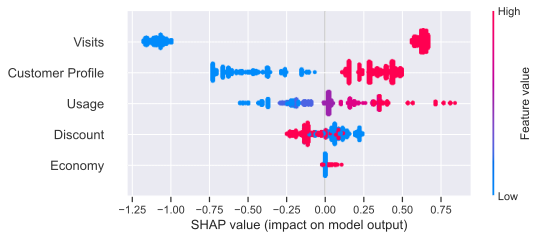

In [16]:
shap.summary_plot(shap_values, features=fg)

## Excluding Visits

In [17]:
X=data.drop(["Renewal","Loyalty","Visits"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model_2 = xgboost.train(
    params, dtrain, num_boost_round=2000,
    evals=((dtest, "test"),), 
    early_stopping_rounds=20, 
    verbose_eval=500
)

fg = X_test.iloc[background_size:foreground_size+background_size]
bg = X_test.iloc[:background_size]

explainer = shap.Explainer(model_2, bg)
shap_values = explainer.shap_values(fg)

[0]	test-logloss:0.67688
[73]	test-logloss:0.60349


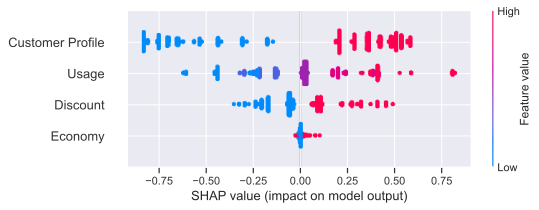

In [18]:
shap.summary_plot(shap_values, features=fg)

# Calculation Of Average Causal Effect

Let us assume that the objective is to appraise the effect of a discount on subscriber renewal. 

## True Average Causal Effect with causal model

The query for the total causal effect is the quantification of the probability $P(Y|do(X))$.

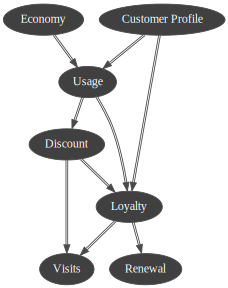

In [19]:
cm=csl.CausalModel(bn)
gum.causal.notebook.showCausalModel(cm, size="4!")

In particular, backdoor adjustment defines a set of variables that should be considered. PyAgrum gives us directly the set to consider.

In [20]:
cslnb.showCausalImpact(cm,"Renewal", {"Discount"})

In [21]:
f, p, s = gum.causal.causalImpact(cm=cm, on="Renewal", doing={"Discount"})
average_uplift_Discount = (p.extract({'Discount':1}) - p.extract({'Discount':0}))[1]
print(f'ACE (ground truth) = {average_uplift_Discount:.2%}')

ACE (ground truth) = 6.89%


## PDP Calculation
Feature selection should satisfy back-door criterion (e.g. model_2). The backdoor adjustment can be estimated from a sample population using a predictive model trained with an off-the-shelf algorithm such as XGBoost. The calculation involves a Monte-Carlo integration over a sample population of size $N$.

In [22]:
population = X_test.copy()
population['Discount'] = 1
population['yhat'] = model_2.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.635129

In [23]:
population = X_test.copy()
population['Discount'] = 0
population['yhat'] = model_2.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.56607014

We then compare the exact ACE with estimates from $100$ sample populations of size $N=10\,000$. For each sample population, we trained four predictive models involving different feature selections:
* _minimal_: a minimal set of features that satisfies the backdoor criterion, here {_Discount_,_Usage_},
* _compatible_: a larger set of features compatible with the backdoor criterion; adding {_Customer Profile_} to the minimal set,
* _missing confounder_: a set of features that does not satisfy the backdoor criterion because it excludes a variable needed to block a path between the action and the target, here excluding _Usage_ from the _compatible_ set, 
* _all variables_: the set of all known features, incompatible with the backdoor criterion because it contains a consequence of the action, namely _Visits_. 

In [24]:
selections = {'minimal':['Discount','Usage'],
              'compatible':['Discount','Customer Profile','Usage'], 
              'missing confounder':['Discount','Customer Profile'],
              'all variables':['Discount','Usage', 'Visits']}

s = []
estimated = []

for key, selection in selections.items():
    X = data[selection].astype('float')
    
    for i in range(100):
        X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, train_size=10000, test_size=5000)

        dtrain = xgboost.DMatrix(X_train, label=y_train)
        dtest = xgboost.DMatrix(X_test, label=y_test)

        model = xgboost.train(
            params, dtrain, num_boost_round=200,
            evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False)
        population = X_test.copy()
        population['Discount'] = 1
        do_1 = np.mean(model.predict(xgboost.DMatrix(population)))
        population['Discount'] = 0
        do_0 = np.mean(model.predict(xgboost.DMatrix(population)))
    
        s.append(key)
        estimated.append(do_1 - do_0)
        
results = pd.DataFrame()
results['selection'] = s
results['estimated'] = estimated

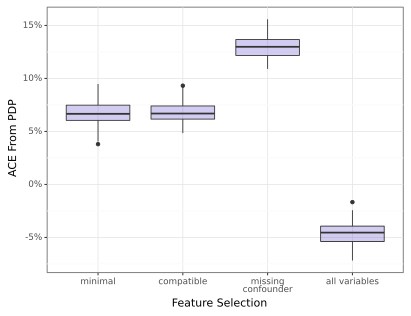

<ggplot: (106704215167)>

In [25]:
results['Feature Selection'] = pd.Categorical(results.selection, 
                                              ['minimal', 'compatible', 'missing confounder', 'all variables'])
# p9.options.figure_size=(,8)
(ggplot(results)
+ geom_boxplot(mapping=aes(x='Feature Selection', y='estimated'), fill="slateblue", alpha=0.3)
#+ geom_jitter(mapping=aes(x='selection', y='estimated'), color="black", size=0.4, alpha=0.7)
# + geom_hline(yintercept=average_uplift_Discount, color='red', linetype='--', size=1.2)
# + annotate('text', label='Exact ACE', x='all variables', y = average_uplift_Discount+0.005, color='red', size=15)
+ scale_y_continuous(name='ACE From PDP', labels=percent_format()) 
+ scale_x_discrete(labels = ['minimal', 'compatible', "missing\nconfounder", 'all variables'])
+ theme_bw()
# + p9.theme(text=p9.element_text(size=20))
)

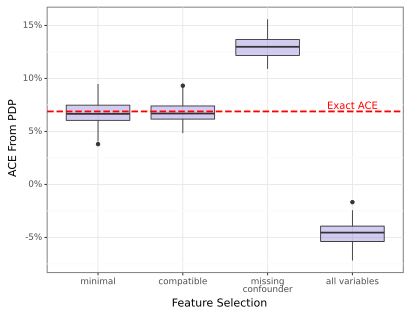

<ggplot: (106703203995)>

In [26]:
results['Feature Selection'] = pd.Categorical(results.selection, 
                                              ['minimal', 'compatible', 'missing confounder', 'all variables'])
# p9.options.figure_size=(,8)
(ggplot(results)
+ geom_boxplot(mapping=aes(x='Feature Selection', y='estimated'), fill="slateblue", alpha=0.3)
#+ geom_jitter(mapping=aes(x='selection', y='estimated'), color="black", size=0.4, alpha=0.7)
+ geom_hline(yintercept=average_uplift_Discount, color='red', linetype='--', size=1)
+ annotate('text', label='Exact ACE', x='all variables', y = average_uplift_Discount+0.005, color='red', size=10)
+ scale_y_continuous(name='ACE From PDP', labels=percent_format()) 
+ scale_x_discrete(labels = ['minimal', 'compatible', "missing\nconfounder", 'all variables'])
+ theme_bw()
# + p9.theme(text=p9.element_text(size=20))
)

In [27]:
print(f'Average Uplift Estimate = {np.mean(average_uplift_Discount):.2%} +/- {np.std(average_uplift_Discount):.2%}')

Average Uplift Estimate = 6.89% +/- 0.00%


It also works with a simpler selection.

In [28]:
X=data.drop(["Renewal","Loyalty","Visits","Customer Profile"], axis=1).astype('float')

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, stratify=y)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

model_3 = xgboost.train(
    params, dtrain, num_boost_round=200000,
    evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=100
)

[0]	test-logloss:0.68330
[87]	test-logloss:0.63890


In [29]:
population = X_test.copy()
population['Discount'] = 1
population['yhat'] = model_3.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.6344045

In [30]:
population = X_test.copy()
population['Discount'] = 0
population['yhat'] = model_3.predict(xgboost.DMatrix(population))
np.mean(population['yhat'])

0.56703645

# Uplift 

Discount have no causal effect on Corporate Customer, by design of the data generator.

Knowing the causal model of the synthetic data generation process, the exact uplift can be exactly computed using pyAgrum. 

In [31]:
cslnb.showCausalImpact(cm,"Renewal", {"Discount"}, knowing={"Customer Profile", "Usage"})

## Do(X) can be replaced with X 
If context satisfies Rule 2 (action/observation exchange) of the do-calculus. Then we can estimate the effect of an intervention on $X$ by directly using conditional probabilities estimated from observational data

In [32]:
f, p, s = gum.causal.causalImpact(cm=cm, on="Renewal", doing={"Discount"}, knowing={'Usage','Customer Profile'})
p

(pyAgrum.Potential<double>@0000018DFEC5BE20) 
                    ||  Renewal          |
Discou|Custom|Usage ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.7400  | 0.2600  |
1     |0     |0     || 0.6600  | 0.3400  |
0     |1     |0     || 0.3400  | 0.6600  |
1     |1     |0     || 0.3400  | 0.6600  |
0     |0     |1     || 0.6840  | 0.3160  |
1     |0     |1     || 0.5400  | 0.4600  |
[...8 more line(s) ...]
0     |1     |3     || 0.2680  | 0.7320  |
1     |1     |3     || 0.2680  | 0.7320  |
0     |0     |4     || 0.5160  | 0.4840  |
1     |0     |4     || 0.1800  | 0.8200  |
0     |1     |4     || 0.2440  | 0.7560  |
1     |1     |4     || 0.2440  | 0.7560  |

In [33]:
ie.evidenceImpact("Renewal", ["Usage","Customer Profile", "Discount"]) - p 

(pyAgrum.Potential<double>@0000018DCD9CB9A0) 
                    ||  Renewal          |
Usage |Discou|Custom||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |0     || 0.0000  | 0.0000  |
2     |0     |0     || -0.0000 | -0.0000 |
3     |0     |0     || -0.0000 | -0.0000 |
4     |0     |0     || 0.0000  | 0.0000  |
0     |1     |0     || 0.0000  | 0.0000  |
[...8 more line(s) ...]
4     |0     |1     || 0.0000  | 0.0000  |
0     |1     |1     || 0.0000  | 0.0000  |
1     |1     |1     || 0.0000  | 0.0000  |
2     |1     |1     || 0.0000  | 0.0000  |
3     |1     |1     || 0.0000  | 0.0000  |
4     |1     |1     || 0.0000  | 0.0000  |

## True Uplift for Customer profile

In [34]:
uplift = (ie.evidenceImpact("Renewal", ["Customer Profile", "Usage","Discount"]).extract({'Discount':1}) 
          - ie.evidenceImpact("Renewal", ["Customer Profile", "Usage","Discount"]).extract({'Discount':0}))
uplift

(pyAgrum.Potential<double>@0000018DFEC5BE60) 
             ||  Renewal          |
Usage |Custom||0        |1        |
------|------||---------|---------|
0     |0     || -0.0800 | 0.0800  |
1     |0     || -0.1440 | 0.1440  |
2     |0     || -0.2080 | 0.2080  |
3     |0     || -0.2720 | 0.2720  |
4     |0     || -0.3360 | 0.3360  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |
2     |1     || 0.0000  | 0.0000  |
3     |1     || 0.0000  | 0.0000  |
4     |1     || 0.0000  | 0.0000  |

## Using a Predictive Model

In practice, several techniques from uplift modeling are applicable to estimate the uplift on the observational dataset: the two-models approach: separated models fitted to the control ($X=0$) and treatment ($X=1$); or the unified model: a single model with the allocated treatment being part of the feature space. We choose here to use the unifed model approach.

## Uplift using a Predictive Model

In [35]:
X=data.drop(["Renewal","Loyalty","Visits"], axis=1).astype('float')
X2=data.drop(["Renewal","Loyalty"], axis=1).astype('float')

result = []
result2 = []

for i in range(100):
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                             random_state=i, 
                                                                             train_size=50000, test_size=5000)
    
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)

    model = xgboost.train(
        params, dtrain, num_boost_round=2000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=None
    )

    apply_df = X_test.copy()
    apply_df['uplift'] = model.predict(xgboost.DMatrix(apply_df.assign(Discount=1))) - model.predict(xgboost.DMatrix(apply_df.assign(Discount=0)))
    result.append(apply_df.groupby(['Usage',
                                    'Customer Profile']).agg(frequency=('uplift','count'),
                                     compatible = ('uplift', 'mean')).reset_index())
    
    X2_train,X2_test,y2_train,y2_test = sklearn.model_selection.train_test_split(X2, y, 
                                                                                 random_state=i, 
                                                                                 train_size=50000, test_size=5000)
    
    dtrain2 = xgboost.DMatrix(X2_train, label=y2_train)
    dtest2 = xgboost.DMatrix(X2_test, label=y2_test)

    model2 = xgboost.train(
        params, dtrain2, num_boost_round=2000,
        evals=((dtest2, "test"),), early_stopping_rounds=20, verbose_eval=None
    )

    apply_df2 = X2_test.copy()
    apply_df2['uplift'] = model2.predict(xgboost.DMatrix(apply_df2.assign(Discount=1))) - model2.predict(xgboost.DMatrix(apply_df2.assign(Discount=0)))
    result2.append(apply_df2.groupby(['Usage','Customer Profile']).agg(frequency=('uplift','count'),
                                                               allfeatures = ('uplift', 'mean')).reset_index())
result = pd.concat(result)
result2 = pd.concat(result2)

In [36]:
result["allfeatures"] = result2["allfeatures"]

expected = []
for i in range(len(result)):
    row = result.iloc[i]
    expected.append(uplift.extract({'Usage':int(row['Usage']),
                                    'Customer Profile':int(row['Customer Profile'])}).toarray()[1])
result['ground truth'] = expected

result['profile'] = np.where(result['Customer Profile'], 'Corporate Customer', 'Residential Customer')

reshaped = result.melt(id_vars=('Usage', 'profile'), 
                    value_vars=['compatible','allfeatures','ground truth'],
                    var_name='selection')                      
reshaped['Usage'] = pd.Categorical(reshaped['Usage'].astype('int'))                                  'f(D,U,C,E)')

condlist = [reshaped.selection == 'ground truth', reshaped.selection == 'allfeatures', ]
choicelist = ['P(R|do(D),C,U)', 'f(D,U,C,E,V)']
reshaped['selection_fig'] =  np.select(condlist, choicelist, default='f(D,U,C,E)')

SyntaxError: unmatched ')' (1423534027.py, line 15)

In [ ]:
(ggplot(data=reshaped[reshaped['selection']!='ground truth'], mapping=aes(x='Usage', y='value'))
 + geom_boxplot(aes(color='selection_fig'), width=0.7)
 + geom_point(data=reshaped[reshaped['selection']=='ground truth'],
              color='white',
              mapping=aes(fill='selection_fig'),
              size=5)
 + scale_y_continuous(name='Uplift', labels=percent_format()) 
 + facet_wrap('~profile')
 + theme_bw()
 + p9.theme(subplots_adjust={'bottom': 0.2})
 + p9.theme(legend_position=(.4, .08), legend_direction='horizontal')
 + scale_fill_manual(name='Causal Model',values='cornflowerblue')
 + scale_color_manual(name='Predictive Model', values=(['green','coral']))
 + coord_flip()
 + ggtitle("Exact vs Predicted Uplift From An Intervention On Discount")
)